In [2]:
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
from glob import glob
import matplotlib.pyplot as plt
# Root directory of the project
# ROOT_DIR = os.path.abspath("../../")

# Import Mask RCNN
# sys.path.append(ROOT_DIR)  # To find local version of the library
from src.config import Config
from src import harz3 as harz
import src.model as modellib
import src.utils as utils
from src import visualize
from src import my_utils as ut

In [3]:
class InferenceConfig(harz.HarzConfig):
    # Set batch size to 1 since we'll be running inference on
    # one image at a time. Batch size = GPU_COUNT * IMAGES_PER_GPU
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1
    DETECTION_MIN_CONFIDENCE = 0.5
    IMAGE_RESIZE_MODE = "square"
    IMAGE_MIN_DIM = 256
    IMAGE_MAX_DIM = 256
config = InferenceConfig()

In [4]:
model = modellib.MaskRCNN(mode="inference", config=config,
                                  model_dir='./log')

In [4]:
weights_path=r'./log/bombmeilerbarrow_better/mask_rcnn_harz_0150.h5'
model.load_weights(weights_path, by_name=True)

In [6]:
dataset_dirX=r'../data/bomb_meiler_barrow_mrcnn/validation/x'
dataset_dirY=r'../data/bomb_meiler_barrow_mrcnn/validation/ys/masks'
dataset = harz.HarzDataset()
dataset.load_harz(dataset_dirX, dataset_dirY,256,256,classnames = ['bomb','meiler','barrows'])
dataset.prepare()

In [7]:
import random
image_id = random.choice(dataset.image_ids)
image, image_meta, gt_class_id, gt_bbox, gt_mask =\
    modellib.load_image_gt(dataset, config, image_id, use_mini_mask=False)
info = dataset.image_info[image_id]
print("image ID: {}.{} ({}) {}".format(info["source"], info["id"], image_id, 
                                       dataset.image_reference(image_id)))
results = model.detect([image], verbose=1)

image ID: harz.1359.tif (71) ../data/bomb_meiler_barrow_mrcnn/validation/x/1359.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32


In [9]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

shape:  (256, 256, 1)


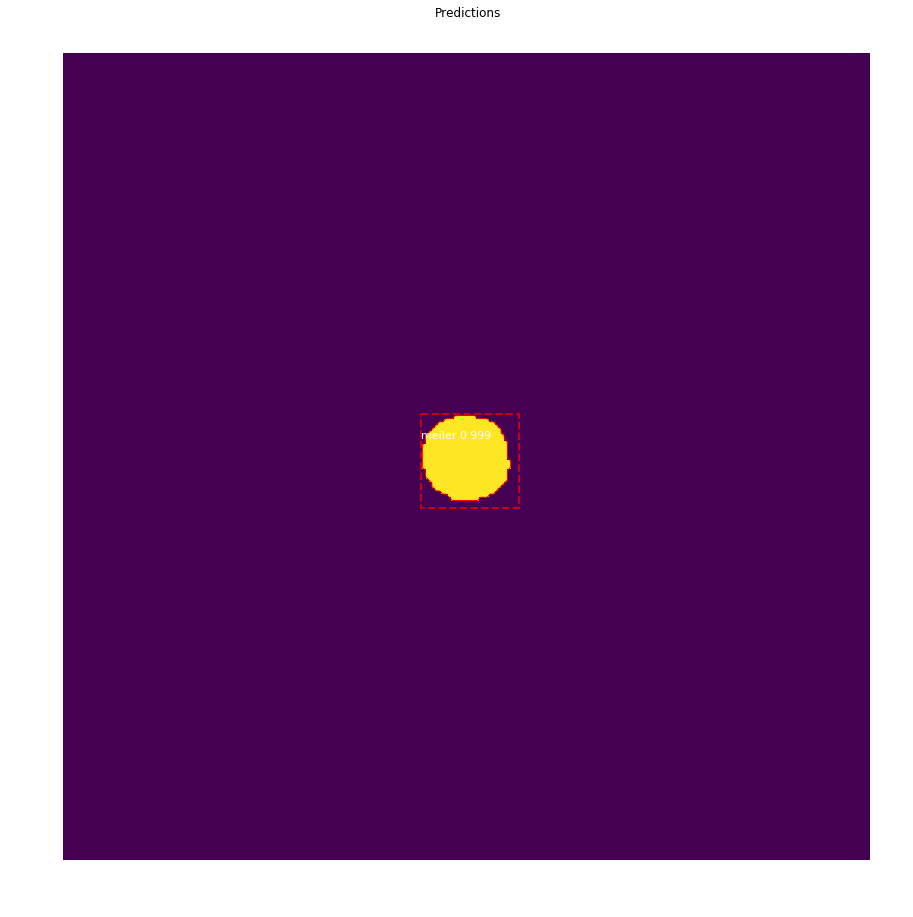

In [12]:
ax = get_ax(1)
r = results[0]
visualize.display_instances(image, r['rois'], r['masks'], r['class_ids'], 
                            dataset.class_names, r['scores'], ax=ax,
                            title="Predictions")

In [30]:
def compute_batch_ap(image_ids,iou_threshold=0.5):
    APs = []
    for image_id in image_ids:
        # Load image
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        # Run object detection
        results = model.detect([image], verbose=0)
        # Compute AP
        r = results[0]
        AP, precisions, recalls, overlaps =\
            utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                              r['rois'], r['class_ids'], r['scores'], r['masks'],iou_threshold=iou_threshold)
        APs.append(AP)
    return APs

In [33]:
iou_threshold = 0.5
APs = compute_batch_ap(dataset.image_ids)
print("mAP @ IoU={}: {}".format(iou_threshold, np.mean(APs)))

mAP @ IoU=0.5: 0.6955544771839856


In [34]:
iou_threshold = 0.75
APs = compute_batch_ap(dataset.image_ids,iou_threshold=iou_threshold)
print("mAP @ IoU={}: {}".format(iou_threshold, np.mean(APs)))

mAP @ IoU=0.75: 0.38669525498923474


In [36]:
images = glob(r'../data/bomb_meiler_barrow_mrcnn/validation/x/*.tif')
results_dir = r'../data/bomb_meiler_barrow_mrcnn/validation/results'
for my_im in images:
    r = harz.detect_and_color_splash(model, my_im)
    ut.write_results_to_polygons(results_dir, my_im, r,height=256,width=256)

Running on ../data/bomb_meiler_barrow_mrcnn/validation/x/259.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_mrcnn/validation/x/984.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16) 

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_mrcnn/validation/x/1040.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_mrcnn/validation/x/393.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_mrcnn/validation/x/1114.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_mrcnn/validation/x/452.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_mrcnn/validation/x/898.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_mrcnn/validation/x/1202.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_mrcnn/validation/x/675.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_mrcnn/validation/x/70.tif
Processing 1 images
image            

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_mrcnn/validation/x/696.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_mrcnn/validation/x/1035.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_mrcnn/validation/x/1375.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_mrcnn/validation/x/880.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas 

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_mrcnn/validation/x/942.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_mrcnn/validation/x/360.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_mrcnn/validation/x/1005.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_mrcnn/validation/x/659.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00

In [5]:
weights_path=r'./log/bombmeilerbarrow/mask_rcnn_harz_0300.h5'
model.load_weights(weights_path, by_name=True)

In [38]:
iou_threshold = 0.5
APs = compute_batch_ap(dataset.image_ids)
print("mAP @ IoU={}: {}".format(iou_threshold, np.mean(APs)))

mAP @ IoU=0.5: 0.8100978212564438


In [39]:
iou_threshold = 0.75
APs = compute_batch_ap(dataset.image_ids,iou_threshold=iou_threshold)
print("mAP @ IoU={}: {}".format(iou_threshold, np.mean(APs)))

mAP @ IoU=0.75: 0.5827067405539216


In [40]:
images = glob(r'../data/bomb_meiler_barrow_mrcnn/validation/x/*.tif')
results_dir = r'../data/bomb_meiler_barrow_mrcnn/validation/results_300'
for my_im in images:
    r = harz.detect_and_color_splash(model, my_im)
    ut.write_results_to_polygons(results_dir, my_im, r,height=256,width=256)

Running on ../data/bomb_meiler_barrow_mrcnn/validation/x/259.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_mrcnn/validation/x/984.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.0

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_mrcnn/validation/x/393.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_mrcnn/validation/x/294.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  sh

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_mrcnn/validation/x/452.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_mrcnn/validation/x/439.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cl

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_mrcnn/validation/x/1202.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_mrcnn/validation/x/1129.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    

Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_mrcnn/validation/x/70.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_mrcnn/validation/x/1035.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_mrcnn/validation/x/1089.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int6

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_mrcnn/validation/x/81.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_mrcnn/validation/x/503.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.0000

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_mrcnn/validation/x/737.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_mrcnn/validation/x/585.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cl

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_mrcnn/validation/x/436.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_mrcnn/validation/x/714.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.

In [9]:
import os, sys
from osgeo import gdal
from gdalconst import GA_ReadOnly

def divide_raster(input_raster, output_folder, tilesize):
    dset = gdal.Open(input_raster, GA_ReadOnly)

    width = dset.RasterXSize
    height = dset.RasterYSize


    for i in range(0, width, tilesize):
        for j in range(0, height, tilesize):
            w = min(i+tilesize, width) - i
            h = min(j+tilesize, height) - j
            gdaltranString = "gdal_translate -of GTIFF -srcwin "+str(i)+", "+str(j)+", "+str(w)+", " \
                +str(h)+" " + input_raster + " " + os.path.join(output_folder,str(i)+"_"+str(j)+".tif")
            os.system(gdaltranString)

In [8]:
from gdalconst import GA_ReadOnly
a = gdal.Open(barrows, GA_ReadOnly)
a.RasterXSize

968

In [13]:
barrows = r'../data/bomb_meiler_barrow_deeplab/testregions/input/test_data_with_barrows.tif'
bombs = r'../data/bomb_meiler_barrow_deeplab/testregions/input/test_data_with_bombs.tif'
meiler = r'../data/bomb_meiler_barrow_deeplab/testregions/input/test_data_with_meiler.tif'

barrow_folder = r'../data/bomb_meiler_barrow_deeplab/testregions/input/barrows'
bombs_folder = r'../data/bomb_meiler_barrow_deeplab/testregions/input/bombs'
meiler_folder = r'../data/bomb_meiler_barrow_deeplab/testregions/input/meiler'

tilesize = 256

divide_raster(barrows, barrow_folder, tilesize)
divide_raster(bombs, bombs_folder, tilesize)
divide_raster(meiler, meiler_folder, tilesize)

In [69]:
meiler = r'../data/bomb_meiler_barrow_deeplab/testregions/input/meiler3.tif'
meiler_folder = r'../data/bomb_meiler_barrow_deeplab/testregions/input/meiler3'
divide_raster(meiler, meiler_folder, tilesize)

In [66]:
images = glob(r'../data/bomb_meiler_barrow_deeplab/testregions/input/barrows/*.tif')
results_dir = r'../data/bomb_meiler_barrow_deeplab/testregions/mrcnn_results/barrows'
for my_im in images:
    r = harz.detect_and_color_splash(model, my_im)
    ut.write_results_to_polygons(results_dir, my_im, r,height=256,width=256)

Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/barrows/768_0.tif
Processing 1 images
image                    shape: (256, 200, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/barrows/512_0.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images      

In [67]:
images = glob(r'../data/bomb_meiler_barrow_deeplab/testregions/input/bombs/*.tif')
results_dir = r'../data/bomb_meiler_barrow_deeplab/testregions/mrcnn_results/bombs'
for my_im in images:
    r = harz.detect_and_color_splash(model, my_im)
    ut.write_results_to_polygons(results_dir, my_im, r,height=256,width=256)

Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/bombs/1280_0.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/bombs/768_0.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:  

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/bombs/0_1024.tif
Processing 1 images
image                    shape: (36, 256, 1)          min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/bombs/768_512.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min: 

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/bombs/512_768.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/bombs/1024_0.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors              

In [68]:
images = glob(r'../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/*.tif')
results_dir = r'../data/bomb_meiler_barrow_deeplab/testregions/mrcnn_results/meiler'
for my_im in images:
    r = harz.detect_and_color_splash(model, my_im)
    ut.write_results_to_polygons(results_dir, my_im, r,height=256,width=256)

Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/5120_4352.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/2816_1792.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/4864_1280.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/1024_2560.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/1280_4608.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/512_2304.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988

Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/5376_5376.tif
Processing 1 images
image                    shape: (88, 256, 1)          min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/4864_1792.tif
Processing 1 images
imag

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/3840_4864.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/3072_2560.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.7098

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/6400_2816.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/4352_1536.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.7098

Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/6400_1792.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/5376_2048.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/6656_768.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/5120_512.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988 

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/5376_5120.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/3072_3840.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.7098

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/3840_5376.tif
Processing 1 images
image                    shape: (88, 256, 1)          min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/4608_256.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float3

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/5632_4096.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/7168_2560.tif
Processing 1 images
image                    shape: (256, 69, 1)          min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/2560_3072.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/5888_3584.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.7098

Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/3840_2816.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler

Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/6912_5120.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler

Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/4864_256.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/6144_4352.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32


Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/7168_4096.tif
Processing 1 images
image                    shape: (256, 69, 1)          min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregio

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/4608_3072.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/512_1792.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/6400_2048.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/256_2816.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32


['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/3072_5120.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/768_1536.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/768_4096.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/6144_4608.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988

anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/5376_1024.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/1280_2304.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00

Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/3840_1280.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/1024_2048.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/1536_0.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  

Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/4352_1024.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/6400_256.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/4608_1024.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/512_4096.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/4352_2816.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/2048_3584.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/3072_0.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4

Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/2048_2304.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions

Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/1280_1536.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/4864_3328.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/4096_3840.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/2304_4864.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/1536_1024.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/5632_4352.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32

Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/6656_4608.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/6144_2816.tif

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/256_4864.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/4608_3584.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors        

Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/5120_3328.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions

Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/4096_5376.tif
Processing 1 images
image                    shape: (88, 256, 1)          min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/2304_1280.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/4608_4096.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/3072_1536.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.7098

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/768_3584.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/2048_0.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  m

image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/0_256.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler/5632_1280.

In [70]:
images = glob(r'../data/bomb_meiler_barrow_deeplab/testregions/input/meiler3/*.tif')
results_dir = r'../data/bomb_meiler_barrow_deeplab/testregions/mrcnn_results/meiler3'
for my_im in images:
    r = harz.detect_and_color_splash(model, my_im)
    ut.write_results_to_polygons(results_dir, my_im, r,height=256,width=256)

Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler3/2816_1792.tif
Processing 1 images
image                    shape: (256, 40, 1)          min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler3/2560_768.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  floa

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler3/1280_512.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler3/256_768.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler3/2048_1792.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler3/512_1792.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors      

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler3/512_2048.tif
Processing 1 images
image                    shape: (97, 256, 1)          min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  float64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler3/1280_2048.tif
Processing 1 images
image                    shape: (97, 256, 1)          min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  float64
anchors                  shape: (1, 

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler3/2048_1024.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler3/1280_768.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.709

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler3/512_1280.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler3/2304_512.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.7098

Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregions/input/meiler3/1280_1024.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/testregion

In [71]:
images = glob(r'../data/bomb_meiler_barrow_deeplab/justmeiler/*.tif')
results_dir = r'../data/bomb_meiler_barrow_deeplab/testregions/mrcnn_results/meiler4'
for my_im in images:
    r = harz.detect_and_color_splash(model, my_im)
    ut.write_results_to_polygons(results_dir, my_im, r,height=256,width=256)

Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen417.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1110.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cl

Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1345.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen914.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen841.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen479.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         m

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen918.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen835.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.4

anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen466.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen977.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1291.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float64
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1139.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)        

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1166.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen813.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  sh

Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1019.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Nieder

Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen704.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen897.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.4

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1048.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1283.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen877.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen880.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float64
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.0000

Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen568.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen388.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float64
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls

Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen959.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen861.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen703.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float64
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen705.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  sha

Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen715.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1089.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen601.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen543.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         m

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1294.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1219.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1064.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen620.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen904.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen720.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         m

Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1327.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1394.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'c

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen955.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1209.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen699.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float64
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1343.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         

Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1091.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen456.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cl

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1009.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1249.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)        

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen906.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float64
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen734.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  sha

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen376.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1229.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1183.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen523.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1043.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1205.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen735.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen868.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         m

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen402.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1366.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         

Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen851.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen506.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen666.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen518.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.4

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen362.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1100.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1267.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen378.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float64
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.

Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1217.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Nieder

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen803.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float64
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1372.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  sh

Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen567.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Nieders

Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen457.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1056.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen471.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.

Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float64
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1133.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barro

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen945.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1087.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  sh

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen611.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float64
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen642.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         m

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen368.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen785.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  sha

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen564.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen750.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.4

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1134.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float64
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1374.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  s

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1093.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen367.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen552.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen396.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float64
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  sha

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen871.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen610.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.4

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1160.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen514.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.

Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float64
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1044.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barro

Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen361.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Nieders

molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1328.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1253.tif
Processing 1 images
image                    shape: (256, 256, 1)        

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1123.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen582.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.

Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen888.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1152.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cl

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1176.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen515.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         

image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen660.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float64
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen925.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
m

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen856.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen997.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         m

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen710.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1169.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1130.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen811.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1200.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float64
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen910.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float64
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         

['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen827.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen549.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         m

Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen1388.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justmeiler/Niedersachsen738.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float64
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cl

In [72]:
images = glob(r'../data/bomb_meiler_barrow_deeplab/justbombs/*.tif')
results_dir = r'../data/bomb_meiler_barrow_deeplab/testregions/mrcnn_results/bombs2'
for my_im in images:
    r = harz.detect_and_color_splash(model, my_im)
    ut.write_results_to_polygons(results_dir, my_im, r,height=256,width=256)

Running on ../data/bomb_meiler_barrow_deeplab/justbombs/Niedersachsen286.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbombs/Niedersachsen219.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbombs/Niedersachsen260.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbombs/Niedersachsen210.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape:

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbombs/Niedersachsen351.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbombs/Niedersachsen291.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.0000

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbombs/Niedersachsen281.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbombs/Niedersachsen298.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.0000

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbombs/Niedersachsen249.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbombs/Niedersachsen307.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)    

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbombs/Niedersachsen279.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbombs/Niedersachsen312.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas     

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbombs/Niedersachsen289.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbombs/Niedersachsen239.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)    

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbombs/Niedersachsen356.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbombs/Niedersachsen263.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
mold

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbombs/Niedersachsen280.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbombs/Niedersachsen254.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)    

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbombs/Niedersachsen347.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbombs/Niedersachsen233.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)    

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbombs/Niedersachsen208.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbombs/Niedersachsen278.tif
Processing 1

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']


In [75]:
images = glob(r'../data/bomb_meiler_barrow_deeplab/justbarrows/*.tif')
results_dir = r'../data/bomb_meiler_barrow_deeplab/testregions/mrcnn_results/barrows2'
for my_im in images:
    r = harz.detect_and_color_splash(model, my_im)
    ut.write_results_to_polygons(results_dir, my_im, r,height=256,width=256)

Running on ../data/bomb_meiler_barrow_deeplab/justbarrows/Niedersachsen190.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbarrows/Niedersachsen111.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)        

Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbarrows/Niedersachsen45.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)       

Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbarrows/Niedersachsen113.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:   

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbarrows/Niedersachsen99.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbarrows/Niedersachsen142.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.000

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbarrows/Niedersachsen180.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbarrows/Niedersachsen159.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbarrows/Niedersachsen47.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox'

Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbarrows/Niedersachsen46.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            s

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbarrows/Niedersachsen120.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbarrows/Niedersachsen179.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)        

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbarrows/Niedersachsen168.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_ba

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbarrows/Niedersachsen3.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbarrows/Niedersachsen118.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas   

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbarrows/Niedersachsen83.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_bar

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbarrows/Niedersachsen188.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbarrows/Niedersachsen125.tif
Processi

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbarrows/Niedersachsen82.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox'

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbarrows/Niedersachsen171.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbarrows/Ni

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbarrows/Niedersachsen164.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbarrows/Niedersachsen122.tif
Processing 1 images
image          

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbarrows/Niedersachsen57.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbarrows/Nie

['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbarrows/Niedersachsen146.tif
Processing 1 images
image                    shape: (256, 256, 1)         min:    0.00000  max:    1.00000  float32
molded_images            shape: (1, 256, 256, 1)      min:    0.00000  max:    1.00000  float64
image_metas              shape: (1, 16)               min:    0.00000  max:  256.00000  int64
anchors                  shape: (1, 16368, 4)         min:   -0.70988  max:    1.45890  float32
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
['BBox', 'cls_id', 'conf']
Running on ../data/bomb_meiler_barrow_deeplab/justbarrows/Ni

In [ ]:
import arcpy  
import os  
#Setting root workspace where files are located  
workspace = r"\\KOKO\tmp\kazimi\data\bomb_meiler_barrow_deeplab\testregions\mrcnn_results\bombs"  
#Making an empty list to put filepaths to feature classes in  
feature_classes = []  
#Walking workspace recursively checking type, and appending filepath to list  
for dirpath, dirnames, filenames in arcpy.da.Walk(workspace,datatype="FeatureClass", type="Polygon"):  
    for filename in filenames:
		if filename != "masks.shp":
			continue
        desc = arcpy.Describe(os.path.join(dirpath, filename))  
        if desc.shapeType == "Polygon":  
            feature_classes.append(os.path.join(dirpath, filename))  
            
#merging my list of feature classes to a new dataset  
arcpy.Merge_management(feature_classes, "merged_pols")

  

  
def do_both(mydict):
    for k, v in mydict.items():
		print(k, v)
        ws, fnames, onames = v
        for fn, on in zip(fnames, onames):
			print(fn, on)
            feature_classes = []
            for dirpath, dirnames, filenames in arcpy.da.Walk(ws,datatype="FeatureClass", type="Polygon"):
                for filename in filenames:
                    if filename != fn:
                        continue
                    desc = arcpy.Describe(os.path.join(dirpath, filename))
                    if desc.shapeType == "Polygon": 
                        feature_classes.append(os.path.join(dirpath, filename))
			print(len(feature_classes))
            arcpy.Merge_management(feature_classes, on)  